In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os
import pandas as pd
import numpy as np
from loguru import logger
from os.path import join as pjoin
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from matplotlib.colors import ListedColormap

In [ ]:
colors = ["#B83945", "#377483", "#E3E457", "#DAA87C", "#D9B9D4", "#C9DCC4", "#C5DFF4", "#7C9895", "#F4EEAC", "#AEB2D1", "#4F845C", "#92A5D1"] # https://www.xiaohongshu.com/explore/65c0b9f9000000000a030e41

USE_TEX = False
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
def config_plot_style():
    # https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    tex_fonts = {
        # Use LaTeX to write all text
        "text.usetex": USE_TEX,
        "font.family": "serif",
        "axes.titlesize": SMALL_SIZE,   # fontsize of the axes title
        "axes.labelsize": MEDIUM_SIZE,  # fontsize of the x and y labels
        "font.size": SMALL_SIZE,        # controls default text sizes
        "legend.fontsize": MEDIUM_SIZE,  # legend fontsize
        "xtick.labelsize": SMALL_SIZE,  # fontsize of the tick labels
        "ytick.labelsize": SMALL_SIZE,  # fontsize of the tick labels
        "figure.titlesize": BIGGER_SIZE,# fontsize of the figure title
    }
    sns.set_theme(rc={'text.usetex' : USE_TEX}) # this needs to be set before the matplotlib
    plt.rcParams.update(tex_fonts)
    
config_plot_style()

In [ ]:
%ls

In [16]:
result_path = max([f for f in os.listdir() if f.startswith("result_") and f.endswith("T.csv")]) # T is part of the config code defined in convert_vlm.py to indicate that SKIP_P0==True
result_df = pd.read_csv(result_path)

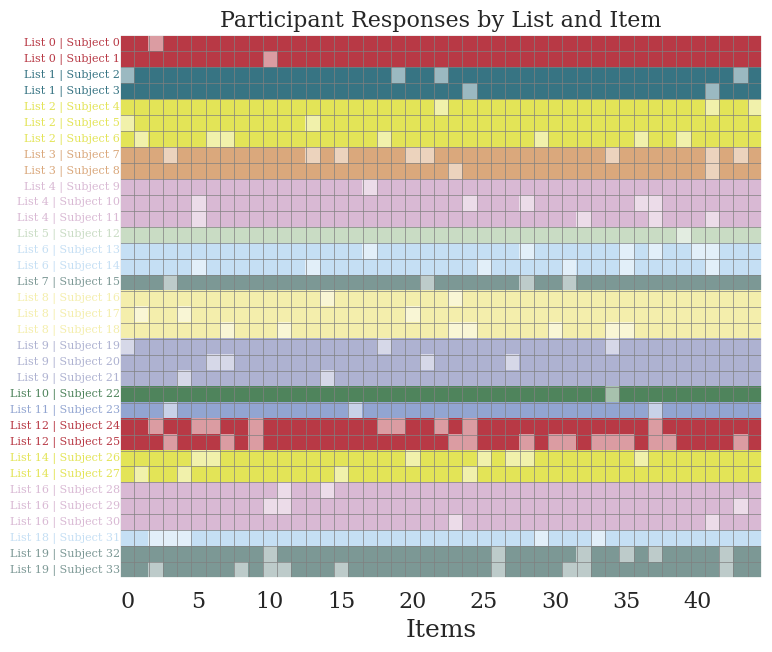

In [30]:
# Initialize lists
all_rows = []
row_labels = []
list_id_for_rows = []

# Process each list_id
n_list_ids = result_df['list_id'].nunique()
n_participants = 0
for list_id in range(n_list_ids):
    # Filter rows for current list_id and GroupKind == "Humans"
    list_df = result_df[(result_df['list_id'] == list_id) & (result_df['GroupKind'] == "Humans")]
    # Get unique participants
    participants = list_df['Participant_ID'].unique()
    
    # Process each participant
    for participant in participants:
        # Filter rows for current participant
        participant_df = list_df[list_df['Participant_ID'] == participant]
        # Expect 45 rows
        if len(participant_df) != 45:
            print(f"Warning: Participant {participant} in list {list_id} has {len(participant_df)} rows, expected 45")
            continue
        
        # Get the 45 binary values
        binary_col = "Accuracy"
        binary_data = participant_df[binary_col].values
        # Add one row to data matrix (45 columns)
        all_rows.append(binary_data)
        # Add row label and list_id for coloring
        row_labels.append(f"List {list_id} | Subject {n_participants}")
        n_participants += 1
        list_id_for_rows.append(list_id)

# Convert to numpy array
data_matrix = np.array(all_rows)

# Create custom colormap: 12 colors for Accuracy=0, 12 for Accuracy=1 (lighter/darker shades)
N = len(colors)  # 12
cmap_colors = []
for color in colors:
    # For Accuracy=0: lighter shade (mix with white)
    lighter = np.array([1, 1, 1]) * 0.5 + np.array([int(color[1:3], 16)/255, int(color[3:5], 16)/255, int(color[5:7], 16)/255]) * 0.5
    # For Accuracy=1: original color
    darker = np.array([int(color[1:3], 16)/255, int(color[3:5], 16)/255, int(color[5:7], 16)/255])
    cmap_colors.extend([lighter, darker])

cmap = ListedColormap(cmap_colors)

# Normalize data: map (list_id, Accuracy) to colormap indices
# Accuracy=0 -> 2*list_id, Accuracy=1 -> 2*list_id+1
normalized_data = np.zeros_like(data_matrix, dtype=float)
for i, list_id in enumerate(list_id_for_rows):
    normalized_data[i] = 2 * (list_id % N) + data_matrix[i]

# Create the heatmap
fig, ax = plt.subplots(figsize=(8, len(all_rows) * 0.2))
cax = ax.imshow(normalized_data, cmap=cmap, aspect='auto', interpolation='nearest')

# Set y-axis labels with colors based on list_id
ax.set_yticks(np.arange(len(row_labels)))
for i, label in enumerate(row_labels):
    color = colors[list_id_for_rows[i] % N]
    ax.text(-0.5, i, label, color=color, fontsize=8, va='center', ha='right')
ax.set_yticklabels([])  # Hide default labels

# Set x-axis labels (items 1 to 45)
#ax.set_xticks(np.arange(45))
#ax.set_xticklabels([f"Item {i+1}" for i in range(45)], rotation=45, ha='right', fontsize=8)

# Add gridlines to align with cells
ax.set_xticks(np.arange(-0.5, 45, 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(all_rows), 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='major', visible=False)

# Labels and title
ax.set_xlabel('Items')
plt.title('Participant Responses by List and Item')

# Adjust layout
plt.tight_layout()